#### Section 3.2 Evaluation of QSAR tools and structural alerts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn import metrics 
from matplotlib.ticker import PercentFormatter

In [3]:
raw_dat_dir = '/home/grace/Documents/python/genetox/data/raw/'
processed_dat_dir = '/home/grace/Documents/python/genetox/data/processed/'
interim_dat_dir = '/home/grace/Documents/python/genetox/data/interim/'
figures_dir = '/home/grace/Documents/python/genetox/reports/figures/'

In [5]:
from sklearn.metrics import confusion_matrix
from itertools import combinations
from sklearn.model_selection import KFold


In [6]:
import sys

sys.path.append('/home/grace/Documents/python/genetox/models/')

from mlfunctions import *

In [7]:
genetox_data = pd.read_excel(raw_dat_dir+'Chemicals&AssayData.xlsx')

In [11]:
df_demarini = pd.read_csv(processed_dat_dir+'DeMariniCalls.csv',index_col = 'CASRN')

In [12]:
tag = {'clastogen':1, 'gentox':1, 'non gentox':0,  'inconclusive':np.nan,
       'not clastogen':0}

In [13]:
df_demarini['DeMarini_outcome'] = df_demarini['DeMarini_call'].replace(tag)

In [16]:
df_demarini.head()

,DeMarini_call,DTXSID,DeMarini_outcome
CASRN,,,
75-07-0,clastogen,DTXSID5039224,1.0
50-81-7,clastogen,DTXSID5020106,1.0
100-52-7,clastogen,DTXSID8039241,1.0
119-53-9,clastogen,DTXSID1020144,1.0
140-11-4,clastogen,DTXSID0020151,1.0


#### Create master dictionary of smiles, casrn and dtxsid 

In [17]:
smiles = pd.read_csv(processed_dat_dir+'smiles.csv')
smiles.index = smiles['CASRN']
smiles['DTXSID'] = df_demarini['DTXSID']

In [18]:
smiles.head()

,CASRN,SMILES,DTXSID
CASRN,,,
75-07-0,75-07-0,CC=O,DTXSID5039224
50-81-7,50-81-7,OCC(O)C1OC(=O)C(O)=C1O,DTXSID5020106
100-52-7,100-52-7,O=CC1=CC=CC=C1,DTXSID8039241
119-53-9,119-53-9,OC(C(=O)C1=CC=CC=C1)C1=CC=CC=C1,DTXSID1020144
140-11-4,140-11-4,CC(=O)OCC1=CC=CC=C1,DTXSID0020151


#### Read Predictions and Alerts

In [38]:

####################################################################################################### 
metrics_tools=pd.DataFrame()
#-------------------------------------------------------------------------------#
# 4.1 EPA TEST Predictions (T1)
#-------------------------------------------------------------------------------#
df_test = pd.read_csv(processed_dat_dir+'TEST_Batch_Mutagenicity_Consensus.txt', sep = '|')[['ID','Pred_Result']]
df_test.rename(columns={'ID':'CASRN','Pred_Result':'TEST'}, inplace = True)
df_test.index = df_test['CASRN']

df_test.replace('Mutagenicity Positive', 1, inplace = True)
df_test.replace('Mutagenicity Negative', 0, inplace = True)

df_test['DTXSID'] = smiles['DTXSID']
df_test.drop_duplicates(inplace=True)

# Calculate Prediction Metrics - compare against DeMarini calls
compare = pd.concat([df_demarini['DeMarini_outcome'], df_test['TEST']], axis = 1, sort = True).dropna()
cnf_matrix = confusion_matrix(compare['DeMarini_outcome'], compare['TEST'])
total, acc, sens, spec, ba, kappa = calcMetrics(cnf_matrix)
metrics_tools.loc['EPA TEST|Williamsetal', 'Truth'] = 'Categorisation_Scheme'
metrics_tools.loc['EPA TEST|Williamsetal', 'Total'] = total 
metrics_tools.loc['EPA TEST|Williamsetal', 'Accuracy'] = acc 
metrics_tools.loc['EPA TEST|Williamsetal', 'Sensitivity'] = sens 
metrics_tools.loc['EPA TEST|Williamsetal', 'Specificity'] = spec 
metrics_tools.loc['EPA TEST|Williamsetal', 'Balanced Accuracy'] = ba 
metrics_tools.loc['EPA TEST|Williamsetal', 'Kappa'] = kappa
# Rename Column ##
df_test.rename(columns={'TEST':'T1'}, inplace = True)


In [41]:
print(confusion_matrix(compare['DeMarini_outcome'], compare['TEST']))

from sklearn.metrics import classification_report
print(classification_report(compare['DeMarini_outcome'], compare['TEST']))

[[1140  176]
 [ 400  502]]
              precision    recall  f1-score   support

         0.0       0.74      0.87      0.80      1316
         1.0       0.74      0.56      0.64       902

    accuracy                           0.74      2218
   macro avg       0.74      0.71      0.72      2218
weighted avg       0.74      0.74      0.73      2218



#### LAZAR Predictions (T2)

In [42]:

#-------------------------------------------------------------------------------#
lazar1 = pd.read_csv(processed_dat_dir+'2020-01-14_lazar_batch_prediction_smiles1.csv')
lazar1.index = lazar1.CASRN

lazar2 = pd.read_csv(processed_dat_dir+'2020-01-14_lazar_batch_prediction_smiles2.csv')
lazar2.index = lazar2.CASRN

# Combine and convert into binary predictions 
df_lazar = pd.concat([lazar1, lazar2])
df_lazar.replace('mutagenic', 1, inplace = True)
df_lazar.replace('non-mutagenic', 0, inplace = True)

df_lazar = df_lazar[['CASRN', 'Prediction']]
df_lazar['DTXSID'] = smiles['DTXSID']
df_lazar.rename(columns={'Prediction': 'Lazar'}, inplace = True)

df_lazar.drop_duplicates(inplace=True)

## Calculate Prediction Metrics - compare with DeMarini calls
compare = pd.concat([df_demarini['DeMarini_outcome'], df_lazar['Lazar']], axis = 1, sort = True).dropna()
cnf_matrix = confusion_matrix(compare['DeMarini_outcome'], compare['Lazar'])
total, acc, sens, spec, ba, kappa = calcMetrics(cnf_matrix)
metrics_tools.loc['Lazar|Williamsetal', 'Truth'] = 'Categorisation_Scheme'
metrics_tools.loc['Lazar|Williamsetal', 'Total'] = total 
metrics_tools.loc['Lazar|Williamsetal', 'Accuracy'] = acc 
metrics_tools.loc['Lazar|Williamsetal', 'Sensitivity'] = sens 
metrics_tools.loc['Lazar|Williamsetal', 'Specificity'] = spec 
metrics_tools.loc['Lazar|Williamsetal', 'Balanced Accuracy'] = ba 
metrics_tools.loc['Lazar|Williamsetal', 'Kappa'] = kappa
# Rename Column ##
df_lazar.rename(columns={'Lazar':'T2'}, inplace = True)


In [43]:
df_lazar.shape

(4308, 3)

#### OECD Toolbox Predictions (Save the oecd.csv as tab delimited text file) 

In [44]:

#-------------------------------------------------------------------------------#
df_oecd = pd.read_csv(processed_dat_dir+'oecd.txt', sep = '\t', encoding = "ISO-8859-1")
#df_oecd.rename(columns={'CAS Number': 'CASRN'}, inplace = True)

for idx in df_oecd.index:
    cas = df_oecd.loc[idx,'CASRN']
    df_oecd.loc[idx,'DTXSID'] = smiles[smiles['CASRN']==cas]['DTXSID'].values

df_oecd.index = df_oecd['CASRN']
df_oecd = df_oecd[['DNA alerts for AMES by OASIS',\
            'DNA alerts for CA and MNT by OASIS',\
            'Protein binding alerts for Chromosomal aberration by OASIS',\
            'in vitro mutagenicity (Ames test) alerts by ISS',\
            'in vivo mutagenicity (Micronucleus) alerts by ISS']]

df_oecd['DNA alerts for AMES by OASIS'] = df_oecd['DNA alerts for AMES by OASIS'].apply(lambda x: 0 if x == 'No alert found' else 1)
df_oecd['DNA alerts for CA and MNT by OASIS'] = df_oecd['DNA alerts for CA and MNT by OASIS'].apply(lambda x: 0 if x == 'No alert found' else 1)
df_oecd['Protein binding alerts for Chromosomal aberration by OASIS'] = df_oecd['Protein binding alerts for Chromosomal aberration by OASIS'].apply(lambda x: 0 if x == 'No alert found' else 1)
df_oecd['in vitro mutagenicity (Ames test) alerts by ISS'] = df_oecd['in vitro mutagenicity (Ames test) alerts by ISS'].apply(lambda x: 0 if x == 'No alert found' else 1)
df_oecd['in vivo mutagenicity (Micronucleus) alerts by ISS'] = df_oecd['in vivo mutagenicity (Micronucleus) alerts by ISS'].apply(lambda x: 0 if x == 'No alert found' else 1)

# Rename alerts A1, A2 etc ##
df_oecd.rename(columns={'DNA alerts for AMES by OASIS':'A1',\
                     'DNA alerts for CA and MNT by OASIS':'A2',\
                     'Protein binding alerts for Chromosomal aberration by OASIS':'A3',\
                     'in vitro mutagenicity (Ames test) alerts by ISS': 'A4',\
                     'in vivo mutagenicity (Micronucleus) alerts by ISS': 'A5',}, inplace = True)

# Drop duplciated CASRNs
df_oecd = df_oecd.reset_index().drop_duplicates(subset='CASRN', keep='last').set_index('CASRN')


In [45]:
df_oecd.shape

(4260, 5)

In [46]:
# Calculate Prediction Metrics - compare with DeMarini calls
compare = pd.concat([df_demarini['DeMarini_outcome'], df_oecd], axis = 1, sort = True).dropna()
cnf_matrix = confusion_matrix(compare['DeMarini_outcome'], compare['A1'])
total, acc, sens, spec, ba, kappa = calcMetrics(cnf_matrix)
metrics_tools.loc['OECD A1|Williamsetal', 'Truth'] = 'Categorisation_Scheme'
metrics_tools.loc['OECD A1|Williamsetal', 'Total'] = total 
metrics_tools.loc['OECD A1|Williamsetal', 'Accuracy'] = acc 
metrics_tools.loc['OECD A1|Williamsetal', 'Sensitivity'] = sens 
metrics_tools.loc['OECD A1|Williamsetal', 'Specificity'] = spec 
metrics_tools.loc['OECD A1|Williamsetal', 'Balanced Accuracy'] = ba 
metrics_tools.loc['OECD A1|Williamsetal', 'Kappa'] = kappa

cnf_matrix = confusion_matrix(compare['DeMarini_outcome'], compare['A2'])
total, acc, sens, spec, ba, kappa = calcMetrics(cnf_matrix)
metrics_tools.loc['OECD A2|Williamsetal', 'Truth'] = 'Categorisation_Scheme'
metrics_tools.loc['OECD A2|Williamsetal', 'Total'] = total 
metrics_tools.loc['OECD A2|Williamsetal', 'Accuracy'] = acc 
metrics_tools.loc['OECD A2|Williamsetal', 'Sensitivity'] = sens 
metrics_tools.loc['OECD A2|Williamsetal', 'Specificity'] = spec 
metrics_tools.loc['OECD A2|Williamsetal', 'Balanced Accuracy'] = ba 
metrics_tools.loc['OECD A2|Williamsetal', 'Kappa'] = kappa

cnf_matrix = confusion_matrix(compare['DeMarini_outcome'], compare['A3'])
total, acc, sens, spec, ba, kappa = calcMetrics(cnf_matrix)
metrics_tools.loc['OECD A3|Williamsetal', 'Truth'] = 'Categorisation_Scheme'
metrics_tools.loc['OECD A3|Williamsetal', 'Total'] = total 
metrics_tools.loc['OECD A3|Williamsetal', 'Accuracy'] = acc 
metrics_tools.loc['OECD A3|Williamsetal', 'Sensitivity'] = sens 
metrics_tools.loc['OECD A3|Williamsetal', 'Specificity'] = spec 
metrics_tools.loc['OECD A3|Williamsetal', 'Balanced Accuracy'] = ba 
metrics_tools.loc['OECD A3|Williamsetal', 'Kappa'] = kappa

cnf_matrix = confusion_matrix(compare['DeMarini_outcome'], compare['A4'])
total, acc, sens, spec, ba, kappa = calcMetrics(cnf_matrix)
metrics_tools.loc['OECD A4|Williamsetal', 'Truth'] = 'Categorisation_Scheme'
metrics_tools.loc['OECD A4|Williamsetal', 'Total'] = total 
metrics_tools.loc['OECD A4|Williamsetal', 'Accuracy'] = acc 
metrics_tools.loc['OECD A4|Williamsetal', 'Sensitivity'] = sens 
metrics_tools.loc['OECD A4|Williamsetal', 'Specificity'] = spec 
metrics_tools.loc['OECD A4|Williamsetal', 'Balanced Accuracy'] = ba 
metrics_tools.loc['OECD A4|Williamsetal', 'Kappa'] = kappa

cnf_matrix = confusion_matrix(compare['DeMarini_outcome'], compare['A5'])
total, acc, sens, spec, ba, kappa = calcMetrics(cnf_matrix)
metrics_tools.loc['OECD A5|Williamsetal', 'Truth'] = 'Categorisation_Scheme'
metrics_tools.loc['OECD A5|Williamsetal', 'Total'] = total 
metrics_tools.loc['OECD A5|Williamsetal', 'Accuracy'] = acc 
metrics_tools.loc['OECD A5|Williamsetal', 'Sensitivity'] = sens 
metrics_tools.loc['OECD A5|Williamsetal', 'Specificity'] = spec 
metrics_tools.loc['OECD A5|Williamsetal', 'Balanced Accuracy'] = ba 
metrics_tools.loc['OECD A5|Williamsetal', 'Kappa'] = kappa

metrics_tools.to_csv(processed_dat_dir+'metrics_tools.csv', index_label = 'Tool|Truth Combination')


#### Table 5 Performance metrics of in silico tools and structural alerts against the genotoxicity categorisation scheme

In [47]:
metrics_tools

,Truth,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa
EPA TEST|Williamsetal,Categorisation_Scheme,2218.0,74.03,74.04,74.03,74.03,0.44
Lazar|Williamsetal,Categorisation_Scheme,2541.0,73.20,68.66,75.49,72.07,0.42
OECD A1|Williamsetal,Categorisation_Scheme,2750.0,71.13,87.32,67.70,77.51,0.35
OECD A2|Williamsetal,Categorisation_Scheme,2750.0,71.20,85.46,67.96,76.71,0.36
OECD A3|Williamsetal,Categorisation_Scheme,2750.0,61.71,63.30,61.46,62.38,0.13
OECD A4|Williamsetal,Categorisation_Scheme,2750.0,72.18,69.44,73.74,71.59,0.42
OECD A5|Williamsetal,Categorisation_Scheme,2750.0,60.91,52.33,74.21,63.27,0.24


In [36]:
metrics_tools.describe()

,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,2644.142857,69.194286,71.507143,70.655714,71.080000,0.337143
std,203.414543,5.488749,12.238214,5.122925,6.050766,0.113536
min,2218.000000,60.910000,52.330000,61.460000,62.380000,0.130000
25%,2645.500000,66.420000,65.980000,67.830000,67.430000,0.295000
50%,2750.000000,71.200000,69.440000,73.740000,72.070000,0.360000
75%,2750.000000,72.690000,79.750000,74.120000,75.370000,0.420000
max,2750.000000,74.030000,87.320000,75.490000,77.510000,0.440000


#### Figure 3: Combine all the tools into a single dataframe and check the correlation

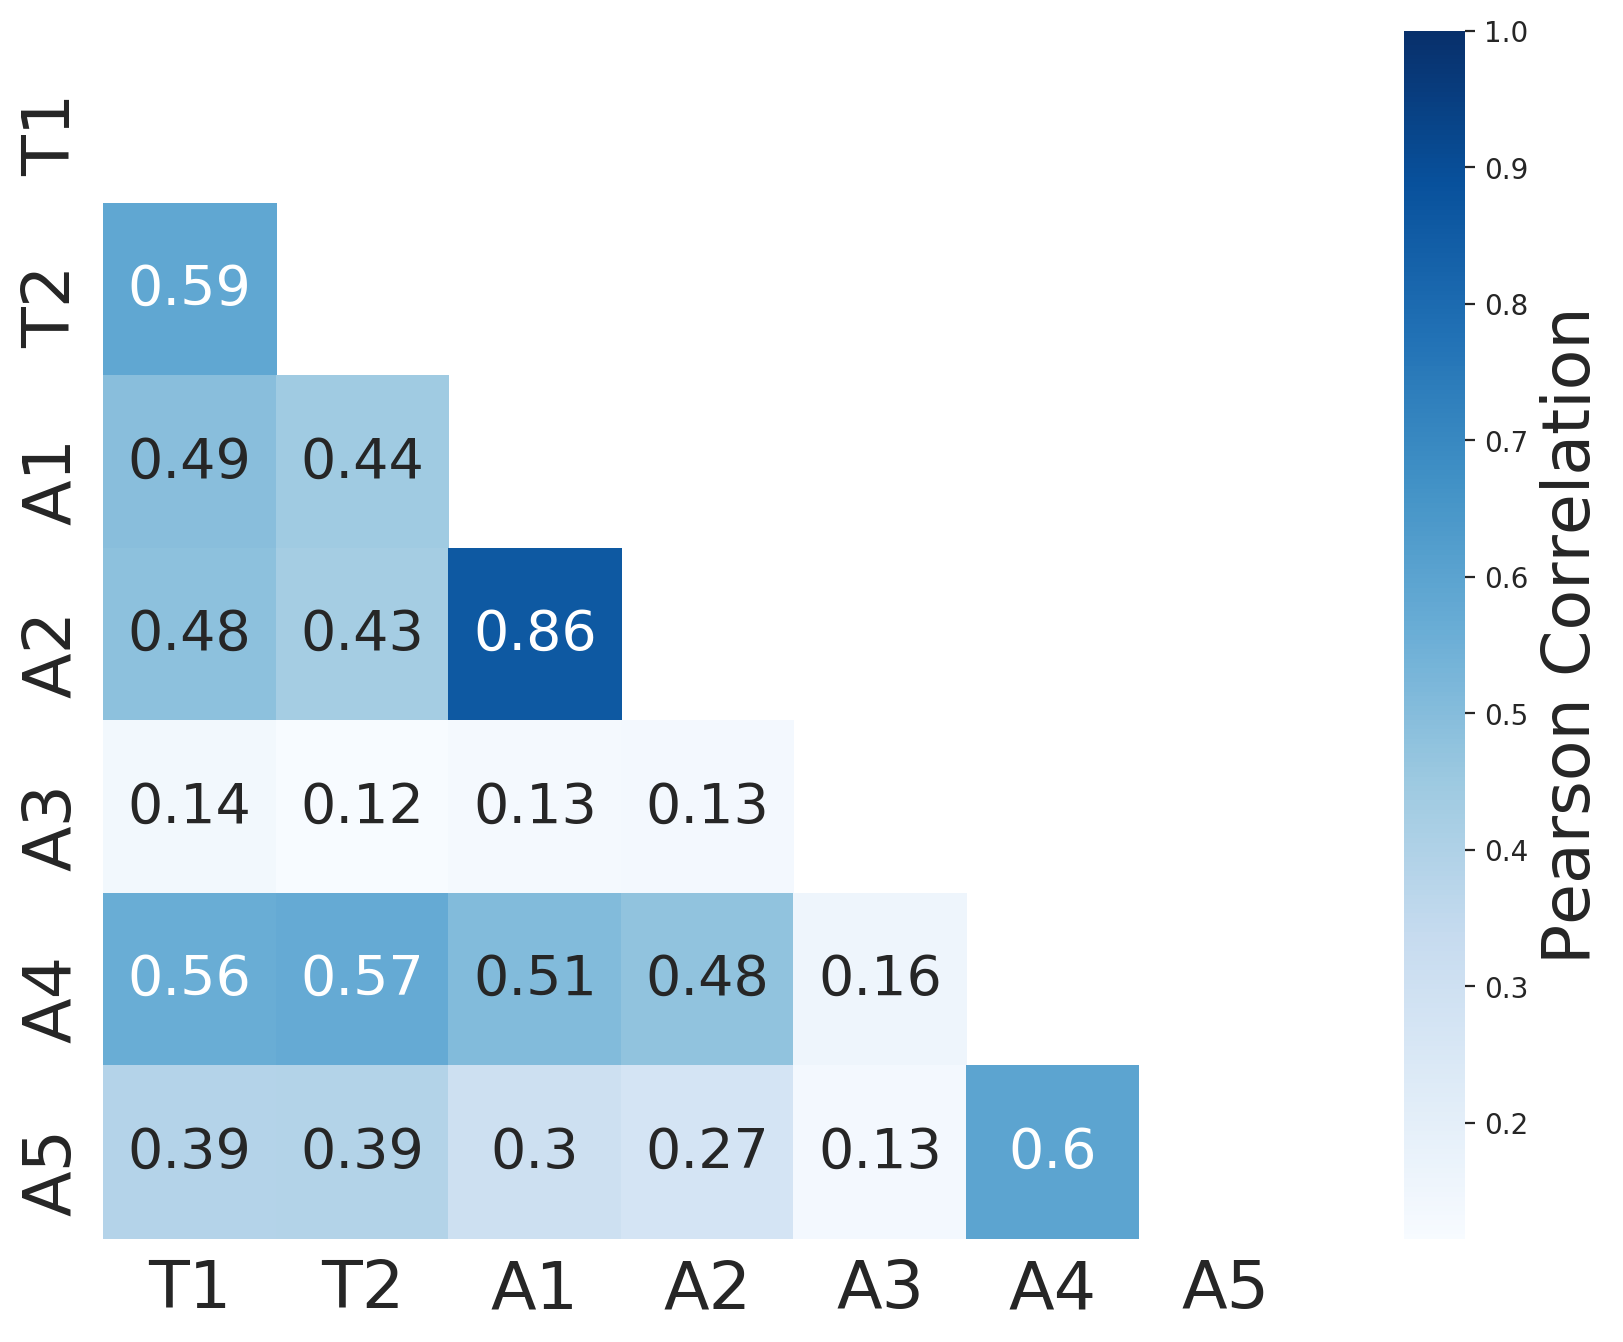

In [48]:

x = pd.concat([df_test['T1'], df_lazar['T2'], df_oecd], axis = 1, sort=True)

# Evaluate and plot correlation
corr_pearson = x.corr(method='pearson')
plt.figure(figsize=(12, 8), dpi = 200)
mask = np.zeros_like(corr_pearson)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr_pearson, mask=mask, vmax=1, square=True, cmap="Blues", 
                     annot=True, cbar_kws={'label': 'Pearson Correlation'}, annot_kws={"size": 20})
ax.figure.axes[-1].yaxis.label.set_size(24)    
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.savefig(figures_dir+'ToolsCorr.png', bbox_inches='tight')    

#### Remove columns with >80% correlation to be used as descriptors in the ensemble model

In [49]:
x = correlation(x, 0.80)

In [93]:
x

,T1,T2,A1,A3,A4,A5
100-00-5,1.0,1.0,1.0,0.0,1.0,1.0
100-01-6,1.0,1.0,1.0,0.0,1.0,1.0
100-02-7,0.0,1.0,0.0,0.0,1.0,1.0
100-17-4,1.0,1.0,1.0,0.0,1.0,1.0
100-18-5,NaN,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
NOCAS_47024,0.0,NaN,NaN,NaN,NaN,NaN
NOCAS_859197,NaN,NaN,NaN,NaN,NaN,NaN
NOCAS_860002,0.0,NaN,NaN,NaN,NaN,NaN
NOCAS_860389,0.0,NaN,NaN,NaN,NaN,NaN


#### Calculate combination for all chemicals (Combination 1 and 2)

In [118]:

ntools = len(x.columns)
x_combns = pd.DataFrame(index=x.index)
for n in range(2,ntools+1):
    cc = np.array(list(combinations(x.columns, n)))
    for c in cc:
        # combination 1
        x_combns['comb1_%d-%s'%(n,''.join(c))] = x[c].sum(axis=1)
        # combination 2
        s = 0
        for p, tool in enumerate(c):
            s=s+2**p*x[tool]
        x_combns['comb2_%d-%s'%(n,''.join(c))] = s

combns = x_combns.columns.tolist()

In [103]:
list(range(2,7))

[2, 3, 4, 5, 6]

In [113]:
len(combns)/2

57.0

In [117]:
2**6

64

#### 5-fold CV Predictions

In [127]:
x_combns['demarini'] = df_demarini['DeMarini_outcome']
# Divide into test and training datasets
kf = KFold(n_splits=5) # Define the split - into 5 folds 
kf.get_n_splits(x_combns) # returns the number of splitting iterations in the cross-validator

# Make the predictions
predictions_x_combns = pd.DataFrame()
for train_index, test_index in kf.split(x_combns):
    train_set, test_set = x_combns.iloc[train_index], x_combns.iloc[test_index]
    #Calculate posteriors from training set
    post_prob = {}
    for combn in combns:
        for comb in train_set[combn].dropna().unique():
            try:
                n_comb = len(train_set[train_set[combn]==comb])
                n_1_comb = len(train_set[(train_set[combn]==comb) & (train_set['demarini']==1)])
                post_prob[comb] = round(n_1_comb/n_comb,2)
            except:
                post_prob[comb] = np.nan
                
        # Calculate new predictions for test set
        for idx in test_set.index:
            comb = test_set.loc[idx, combn]
            for prob_cutoff in [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]:
                try:
                    if post_prob[comb] >= prob_cutoff:
                        predictions_x_combns.loc[idx, '%s_PredCutOff%0.2f' %(combn,prob_cutoff)] = 1
                    else:
                        predictions_x_combns.loc[idx, '%s_PredCutOff%0.2f' %(combn,prob_cutoff)] = 0
                except:
                    if comb==0:
                        predictions_x_combns.loc[idx, '%s_PredCutOff%0.2f' %(combn,prob_cutoff)] = 0
                    elif comb==sum([2**x for x in range(1,ntools+1)]):
                        predictions_x_combns.loc[idx, '%s_PredCutOff%0.2f' %(combn,prob_cutoff)] = 1   
                    else:
                        predictions_x_combns.loc[idx, '%s_PredCutOff%0.2f' %(combn,prob_cutoff)] = np.nan #'Cannot predict'    



In [129]:
predictions_x_combns

,comb1_2-T1T2_PredCutOff0.15,comb1_2-T1T2_PredCutOff0.20,comb1_2-T1T2_PredCutOff0.25,comb1_2-T1T2_PredCutOff0.30,comb1_2-T1T2_PredCutOff0.35,comb1_2-T1T2_PredCutOff0.40,comb1_2-T1T2_PredCutOff0.45,comb1_2-T1T2_PredCutOff0.50,comb1_2-T1T2_PredCutOff0.55,comb2_2-T1T2_PredCutOff0.15,...,comb1_6-T1T2A1A3A4A5_PredCutOff0.55,comb2_6-T1T2A1A3A4A5_PredCutOff0.15,comb2_6-T1T2A1A3A4A5_PredCutOff0.20,comb2_6-T1T2A1A3A4A5_PredCutOff0.25,comb2_6-T1T2A1A3A4A5_PredCutOff0.30,comb2_6-T1T2A1A3A4A5_PredCutOff0.35,comb2_6-T1T2A1A3A4A5_PredCutOff0.40,comb2_6-T1T2A1A3A4A5_PredCutOff0.45,comb2_6-T1T2A1A3A4A5_PredCutOff0.50,comb2_6-T1T2A1A3A4A5_PredCutOff0.55
100-00-5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
100-01-6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
100-02-7,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100-17-4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
100-18-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NOCAS_47024,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOCAS_859197,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOCAS_860002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOCAS_860389,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Calculate Prediction Metrics 

In [130]:

x_combns['demarini'] = df_demarini['DeMarini_outcome']
metrics_x_combns = pd.DataFrame(columns = ['EnsembleCombination', 'Truth', 'Prediction_CutOff', 'nTools', 'Total', 'Accuracy', 'Sensitivity', 'Specificity', 'Balanced Accuracy', 'Kappa']) 
for combn in combns:
    # vary over cut-offs used in prediction
    for prob_cutoff in [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]:
        xy = pd.concat([predictions_x_combns['%s_PredCutOff%0.2f' %(combn,prob_cutoff)], x_combns['demarini']], axis = 1).dropna()
        cnf_matrix = confusion_matrix(xy['%s_PredCutOff%0.2f' %(combn,prob_cutoff)],xy['demarini'])
        n = int(combn.split('_')[1][0])
        total, acc, sens, spec, ba, kappa = calcMetrics(cnf_matrix)
        metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'EnsembleCombination'] = combn
        metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Truth'] = 'Williamns et al. 2019 Calls'
        metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Prediction_CutOff'] = prob_cutoff
        metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'nTools'] = 'n=%d' %n
        metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Total'] = total
        metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Accuracy'] = acc
        metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Sensitivity'] = sens
        metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Specificity'] = spec
        metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Balanced Accuracy'] = ba
        metrics_x_combns.loc['%s|%s' %('%s_PredCutOff%0.2f' %(combn,prob_cutoff), 'DeMarini'), 'Kappa'] = kappa
metrics_x_combns.to_csv(processed_dat_dir+'metrics_combns.csv', index_label = 'Combination')




In [131]:
metrics_x_combns

,EnsembleCombination,Truth,Prediction_CutOff,nTools,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa
comb1_2-T1T2_PredCutOff0.15|DeMarini,comb1_2-T1T2,Williamns et al. 2019 Calls,0.15,n=2,2999,48.88,88.08,23.35,55.72,0.1
comb1_2-T1T2_PredCutOff0.20|DeMarini,comb1_2-T1T2,Williamns et al. 2019 Calls,0.2,n=2,2999,70.82,57.4,79.57,68.48,0.38
comb1_2-T1T2_PredCutOff0.25|DeMarini,comb1_2-T1T2,Williamns et al. 2019 Calls,0.25,n=2,2999,71.96,38.04,94.05,66.05,0.35
comb1_2-T1T2_PredCutOff0.30|DeMarini,comb1_2-T1T2,Williamns et al. 2019 Calls,0.3,n=2,2999,71.76,34.49,96.04,65.27,0.34
comb1_2-T1T2_PredCutOff0.35|DeMarini,comb1_2-T1T2,Williamns et al. 2019 Calls,0.35,n=2,2999,71.76,34.49,96.04,65.27,0.34
...,...,...,...,...,...,...,...,...,...,...
comb2_6-T1T2A1A3A4A5_PredCutOff0.35|DeMarini,comb2_6-T1T2A1A3A4A5,Williamns et al. 2019 Calls,0.35,n=6,1799,75.76,58.26,89.19,73.72,0.49
comb2_6-T1T2A1A3A4A5_PredCutOff0.40|DeMarini,comb2_6-T1T2A1A3A4A5,Williamns et al. 2019 Calls,0.4,n=6,1799,76.1,53.91,93.12,73.52,0.49
comb2_6-T1T2A1A3A4A5_PredCutOff0.45|DeMarini,comb2_6-T1T2A1A3A4A5,Williamns et al. 2019 Calls,0.45,n=6,1799,73.93,46.48,94.99,70.73,0.44
comb2_6-T1T2A1A3A4A5_PredCutOff0.50|DeMarini,comb2_6-T1T2A1A3A4A5,Williamns et al. 2019 Calls,0.5,n=6,1799,68.59,30.22,98.04,64.13,0.31


#### Select the best cut-off/metrics for each combination and plot

In [132]:

metrics_toplot = pd.DataFrame(columns=metrics_x_combns.columns)
for combn in combns:
    metrics_toplotsubset1 = metrics_x_combns[metrics_x_combns['EnsembleCombination']==combn]
    metrics_toplotsubset2 = metrics_toplotsubset1[metrics_toplotsubset1['Balanced Accuracy']==metrics_toplotsubset1['Balanced Accuracy'].max()]
    metrics_toplotsubset3 = metrics_toplotsubset2[metrics_toplotsubset2['Prediction_CutOff']==metrics_toplotsubset2['Prediction_CutOff'].max()]
    metrics_toplot=metrics_toplot.append(metrics_toplotsubset3)


In [133]:
metrics_toplot 

,EnsembleCombination,Truth,Prediction_CutOff,nTools,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa
comb1_2-T1T2_PredCutOff0.20|DeMarini,comb1_2-T1T2,Williamns et al. 2019 Calls,0.2,n=2,2999,70.82,57.4,79.57,68.48,0.38
comb2_2-T1T2_PredCutOff0.45|DeMarini,comb2_2-T1T2,Williamns et al. 2019 Calls,0.45,n=2,1988,76.36,50.62,93.91,72.27,0.48
comb1_2-T1A1_PredCutOff0.30|DeMarini,comb1_2-T1A1,Williamns et al. 2019 Calls,0.3,n=2,2999,74.76,53.76,88.44,71.1,0.44
comb2_2-T1A1_PredCutOff0.35|DeMarini,comb2_2-T1A1,Williamns et al. 2019 Calls,0.35,n=2,2008,75.55,62.81,85.36,74.09,0.49
comb1_2-T1A3_PredCutOff0.30|DeMarini,comb1_2-T1A3,Williamns et al. 2019 Calls,0.3,n=2,2999,72.22,54.02,84.09,69.06,0.4
...,...,...,...,...,...,...,...,...,...,...
comb2_5-T1A1A3A4A5_PredCutOff0.25|DeMarini,comb2_5-T1A1A3A4A5,Williamns et al. 2019 Calls,0.25,n=5,2008,75.8,67.85,81.92,74.88,0.5
comb1_5-T2A1A3A4A5_PredCutOff0.35|DeMarini,comb1_5-T2A1A3A4A5,Williamns et al. 2019 Calls,0.35,n=5,2999,75.16,51.82,90.36,71.09,0.45
comb2_5-T2A1A3A4A5_PredCutOff0.25|DeMarini,comb2_5-T2A1A3A4A5,Williamns et al. 2019 Calls,0.25,n=5,2319,72.96,67.45,76.95,72.2,0.44
comb1_6-T1T2A1A3A4A5_PredCutOff0.30|DeMarini,comb1_6-T1T2A1A3A4A5,Williamns et al. 2019 Calls,0.3,n=6,2999,75.93,55.45,89.26,72.36,0.47


In [138]:
metrics_x_combns1 = metrics_toplot[metrics_toplot['EnsembleCombination'].str.contains('comb1')]

In [146]:
print(metrics_x_combns1['Balanced Accuracy'].mean())
print(metrics_x_combns1['Balanced Accuracy'].std())




70.7717543859649
1.7180264038456385


In [154]:
metrics_x_combns1.sort_values(by = 'Balanced Accuracy', ascending = False)

,EnsembleCombination,Truth,Prediction_CutOff,nTools,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa
comb1_5-T1T2A1A3A4_PredCutOff0.30|DeMarini,comb1_5-T1T2A1A3A4,Williamns et al. 2019 Calls,0.3,n=5,2999,76.03,57.99,87.78,72.89,0.48
comb1_3-A1A3A4_PredCutOff0.25|DeMarini,comb1_3-A1A3A4,Williamns et al. 2019 Calls,0.25,n=3,2999,73.66,67.96,77.37,72.66,0.45
comb1_3-T1A1A3_PredCutOff0.25|DeMarini,comb1_3-T1A1A3,Williamns et al. 2019 Calls,0.25,n=3,2999,74.59,62.64,82.38,72.51,0.46
comb1_5-T1T2A1A3A5_PredCutOff0.25|DeMarini,comb1_5-T1T2A1A3A5,Williamns et al. 2019 Calls,0.25,n=5,2999,74.49,63.06,81.94,72.50,0.46
comb1_6-T1T2A1A3A4A5_PredCutOff0.30|DeMarini,comb1_6-T1T2A1A3A4A5,Williamns et al. 2019 Calls,0.3,n=6,2999,75.93,55.45,89.26,72.36,0.47
comb1_4-T2A1A3A4_PredCutOff0.20|DeMarini,comb1_4-T2A1A3A4,Williamns et al. 2019 Calls,0.2,n=4,2999,71.89,74.22,70.37,72.30,0.43
comb1_3-T2A1A3_PredCutOff0.30|DeMarini,comb1_3-T2A1A3,Williamns et al. 2019 Calls,0.3,n=3,2999,73.42,66.86,77.7,72.28,0.44
comb1_4-T1T2A1A4_PredCutOff0.30|DeMarini,comb1_4-T1T2A1A4,Williamns et al. 2019 Calls,0.3,n=4,2999,75.83,55.28,89.21,72.25,0.47
comb1_4-T1A1A3A4_PredCutOff0.20|DeMarini,comb1_4-T1A1A3A4,Williamns et al. 2019 Calls,0.2,n=4,2999,73.19,67.2,77.09,72.15,0.44
comb1_3-T2A1A4_PredCutOff0.20|DeMarini,comb1_3-T2A1A4,Williamns et al. 2019 Calls,0.2,n=3,2999,72.69,68.81,75.22,72.02,0.44


#### Plot the Prediction Metrics

/home/grace/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/grace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


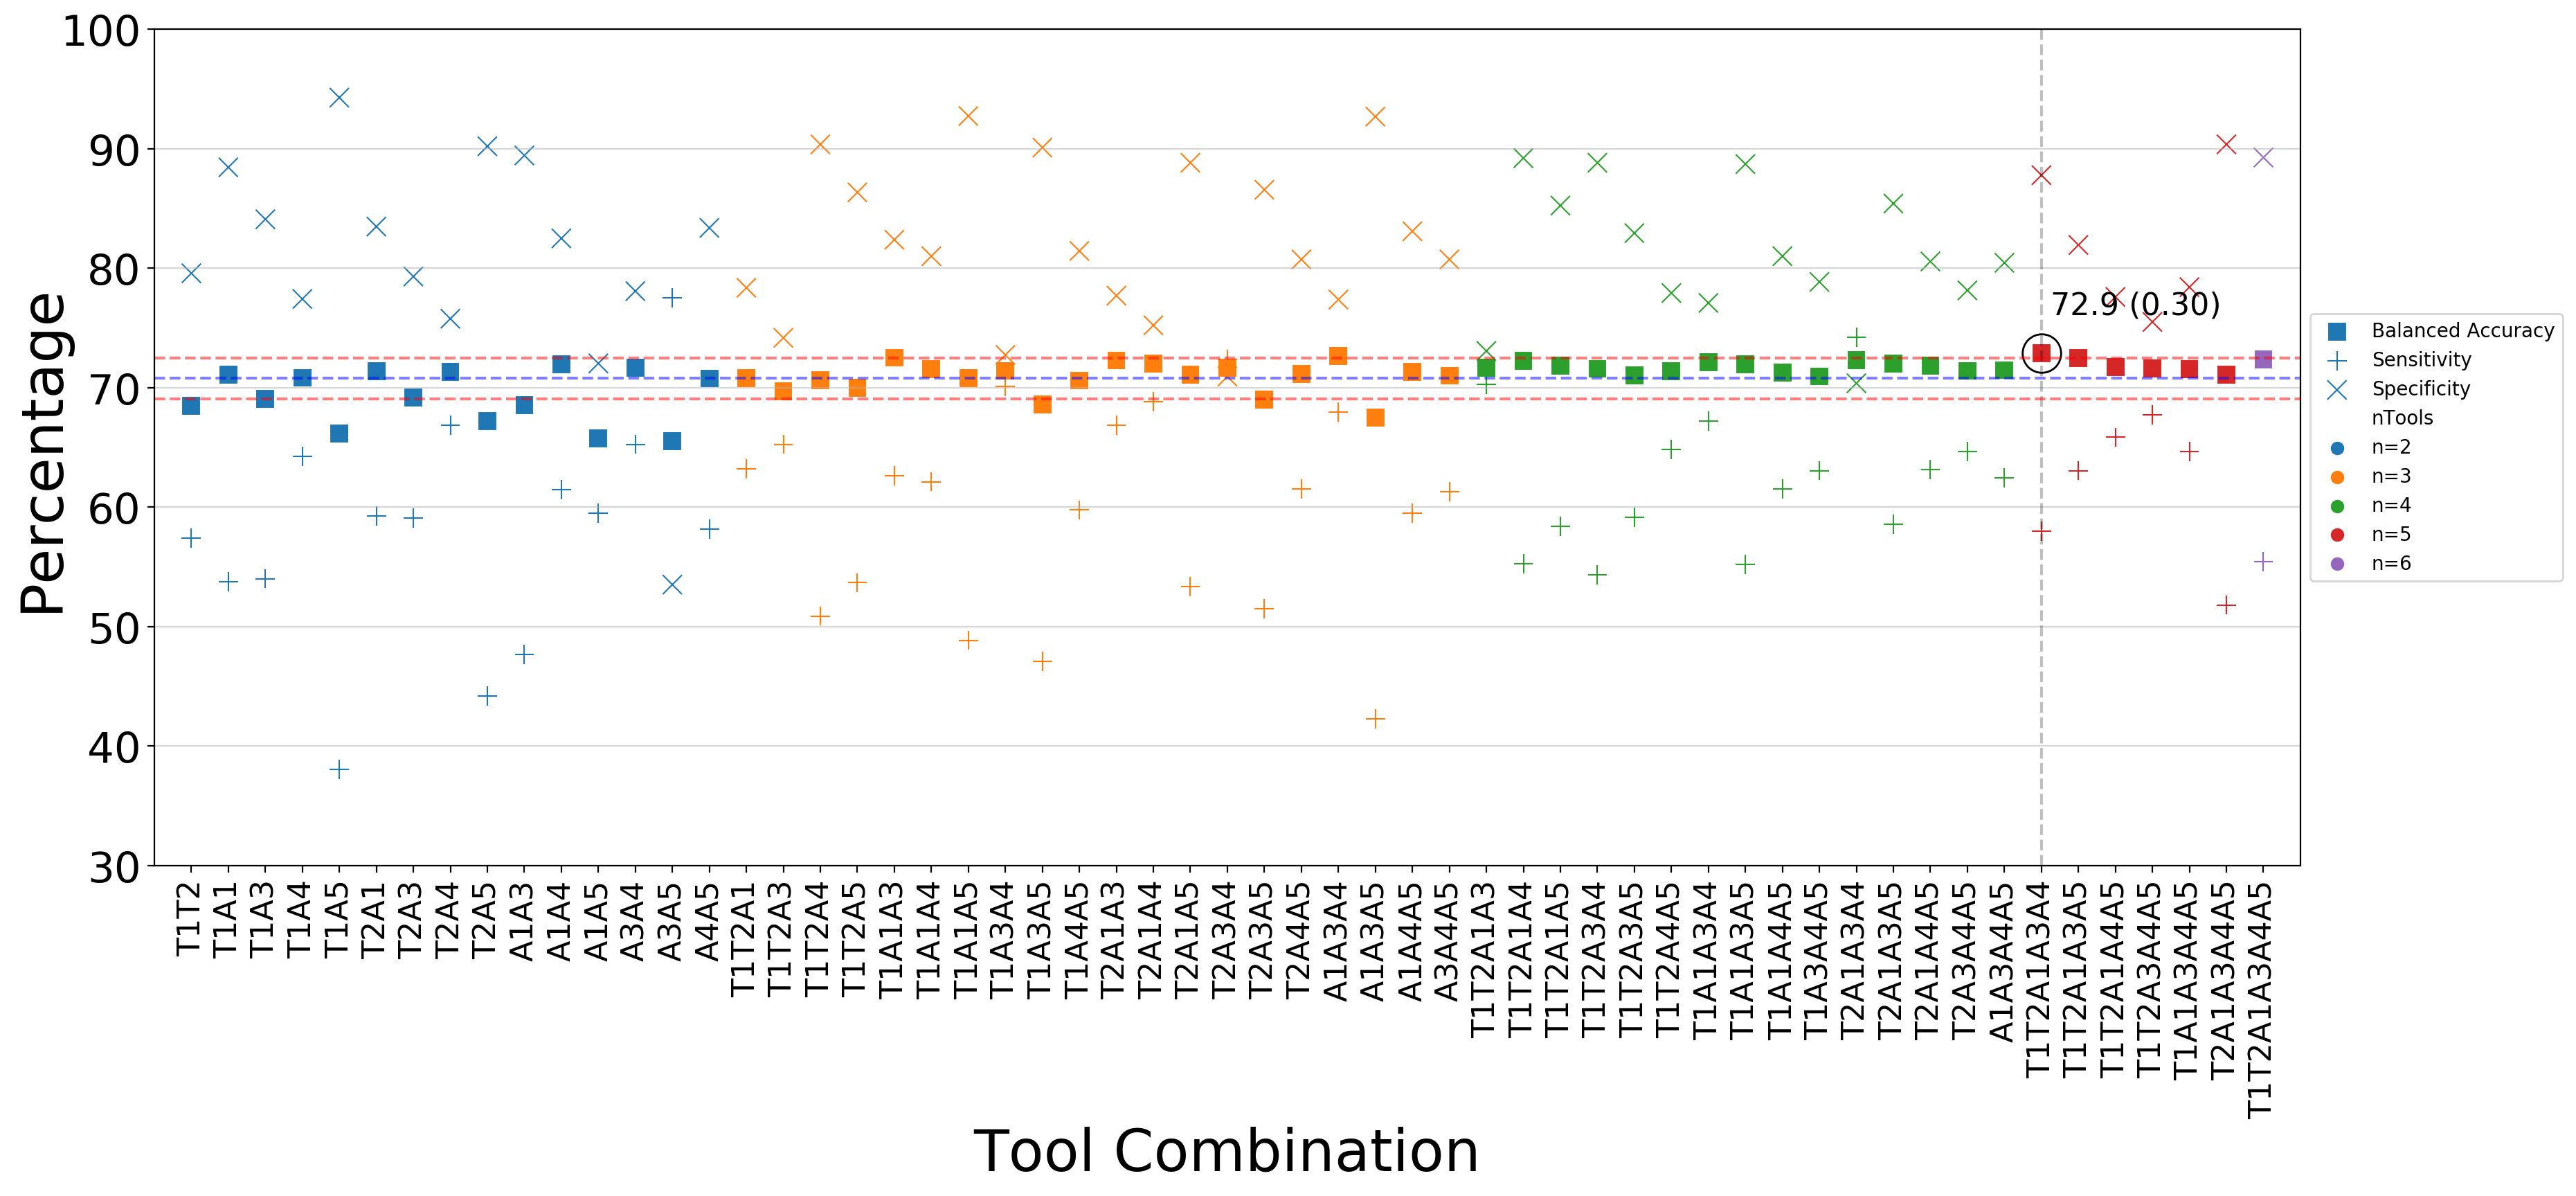

In [147]:

# Set the labels for x-axis - tool combinations
xaxis_label_dup = [combn.split('-')[1] for combn in combns]
xaxis_label = xaxis_label_dup[1::2]

# Combination 1
metrics_x_combns1 = metrics_toplot[metrics_toplot['EnsembleCombination'].str.contains('comb1')]
plt.figure(figsize=(20, 8), dpi = 200)
metrics_x_combns1.nTools=metrics_x_combns1.nTools.astype('category')

ax = sns.scatterplot(x=range(len(metrics_x_combns1)), y = 'Balanced Accuracy', hue='nTools', data=metrics_x_combns1, marker = 's', s=100, label = 'Balanced Accuracy', legend = False)
ax = sns.scatterplot(x=range(len(metrics_x_combns1)), y = 'Sensitivity', hue='nTools', data=metrics_x_combns1, marker = '+', s=100, label = 'Sensitivity', legend = False)
ax = sns.scatterplot(x=range(len(metrics_x_combns1)), y = 'Specificity', hue='nTools', data=metrics_x_combns1, marker = 'x', s=100, label = 'Specificity')

metrics_x_combns1['Balanced Accuracy'] = metrics_x_combns1['Balanced Accuracy'].astype('float')
maxBA = metrics_x_combns1.loc[metrics_x_combns1['Balanced Accuracy'].idxmax()]['Balanced Accuracy']
pcutoff = metrics_x_combns1.loc[metrics_x_combns1['Balanced Accuracy'].idxmax()]['Prediction_CutOff']
maxAccPos = metrics_x_combns1.index.get_loc(metrics_x_combns1['Balanced Accuracy'].idxmax())
plt.plot(maxAccPos,maxBA,marker='o', markersize=20, color = 'k', fillstyle='none')
plt.axvline(maxAccPos, ls = '--', c = 'k', alpha = 0.25)
txt = '%0.1f (%0.2f)' %(maxBA, pcutoff)

plt.axhline(y = metrics_x_combns1['Balanced Accuracy'].mean(), ls = '--', c = 'b', alpha = 0.5)
plt.axhline(y = metrics_x_combns1['Balanced Accuracy'].mean()-metrics_x_combns1['Balanced Accuracy'].std() , ls = '--', c = 'r', alpha = 0.5)
plt.axhline(y = metrics_x_combns1['Balanced Accuracy'].mean()+metrics_x_combns1['Balanced Accuracy'].std() , ls = '--', c = 'r', alpha = 0.5)

plt.annotate(txt, [maxAccPos+0.25,maxBA+3.25], fontsize = 16)

plt.xticks(range(len(metrics_x_combns1)),xaxis_label, fontsize = 16, rotation = 90)
plt.yticks(fontsize = 22)
plt.xlabel('Tool Combination', size = 30)
plt.ylabel('Percentage', size = 30, labelpad = -5)
#plt.legend(fontsize=14, loc='lower right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylim([30,100])
plt.xlim([-1,len(metrics_x_combns1)])
plt.grid(which='major', axis='y', alpha=0.5)
plt.savefig(figures_dir+'MetricsCombn1.png', bbox_inches='tight')


In [150]:
metrics_x_combns2['Balanced Accuracy'].mean()

72.76438596491228

In [151]:
metrics_x_combns2['Balanced Accuracy'].std()

2.2980830657185467

In [153]:
metrics_x_combns2.sort_values(by = 'Balanced Accuracy', ascending = False)

,EnsembleCombination,Truth,Prediction_CutOff,nTools,Total,Accuracy,Sensitivity,Specificity,Balanced Accuracy,Kappa
comb2_5-T1T2A1A3A4_PredCutOff0.25|DeMarini,comb2_5-T1T2A1A3A4,Williamns et al. 2019 Calls,0.25,n=5,1800,77.39,68.67,84.09,76.38,0.53
comb2_4-T1T2A1A4_PredCutOff0.30|DeMarini,comb2_4-T1T2A1A4,Williamns et al. 2019 Calls,0.3,n=4,1800,78.06,60.61,91.45,76.03,0.54
comb2_4-T1T2A1A3_PredCutOff0.30|DeMarini,comb2_4-T1T2A1A3,Williamns et al. 2019 Calls,0.3,n=4,1800,76.94,66.5,84.97,75.73,0.52
comb2_5-T1T2A1A3A5_PredCutOff0.25|DeMarini,comb2_5-T1T2A1A3A5,Williamns et al. 2019 Calls,0.25,n=5,1800,76.39,68.67,82.32,75.50,0.51
comb2_3-T1T2A1_PredCutOff0.25|DeMarini,comb2_3-T1T2A1,Williamns et al. 2019 Calls,0.25,n=3,1800,77.33,60.61,90.18,75.40,0.52
comb2_4-T1T2A1A5_PredCutOff0.30|DeMarini,comb2_4-T1T2A1A5,Williamns et al. 2019 Calls,0.3,n=4,1800,77.56,58.18,92.44,75.31,0.53
comb2_5-T1T2A1A4A5_PredCutOff0.30|DeMarini,comb2_5-T1T2A1A4A5,Williamns et al. 2019 Calls,0.3,n=5,1800,77.39,58.44,91.94,75.19,0.52
comb2_5-T1A1A3A4A5_PredCutOff0.25|DeMarini,comb2_5-T1A1A3A4A5,Williamns et al. 2019 Calls,0.25,n=5,2008,75.8,67.85,81.92,74.88,0.5
comb2_6-T1T2A1A3A4A5_PredCutOff0.30|DeMarini,comb2_6-T1T2A1A3A4A5,Williamns et al. 2019 Calls,0.3,n=6,1799,76.1,65.3,84.38,74.84,0.51
comb2_3-T1A1A3_PredCutOff0.25|DeMarini,comb2_3-T1A1A3,Williamns et al. 2019 Calls,0.25,n=3,2008,75.35,70.82,78.84,74.83,0.5


/home/grace/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/grace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


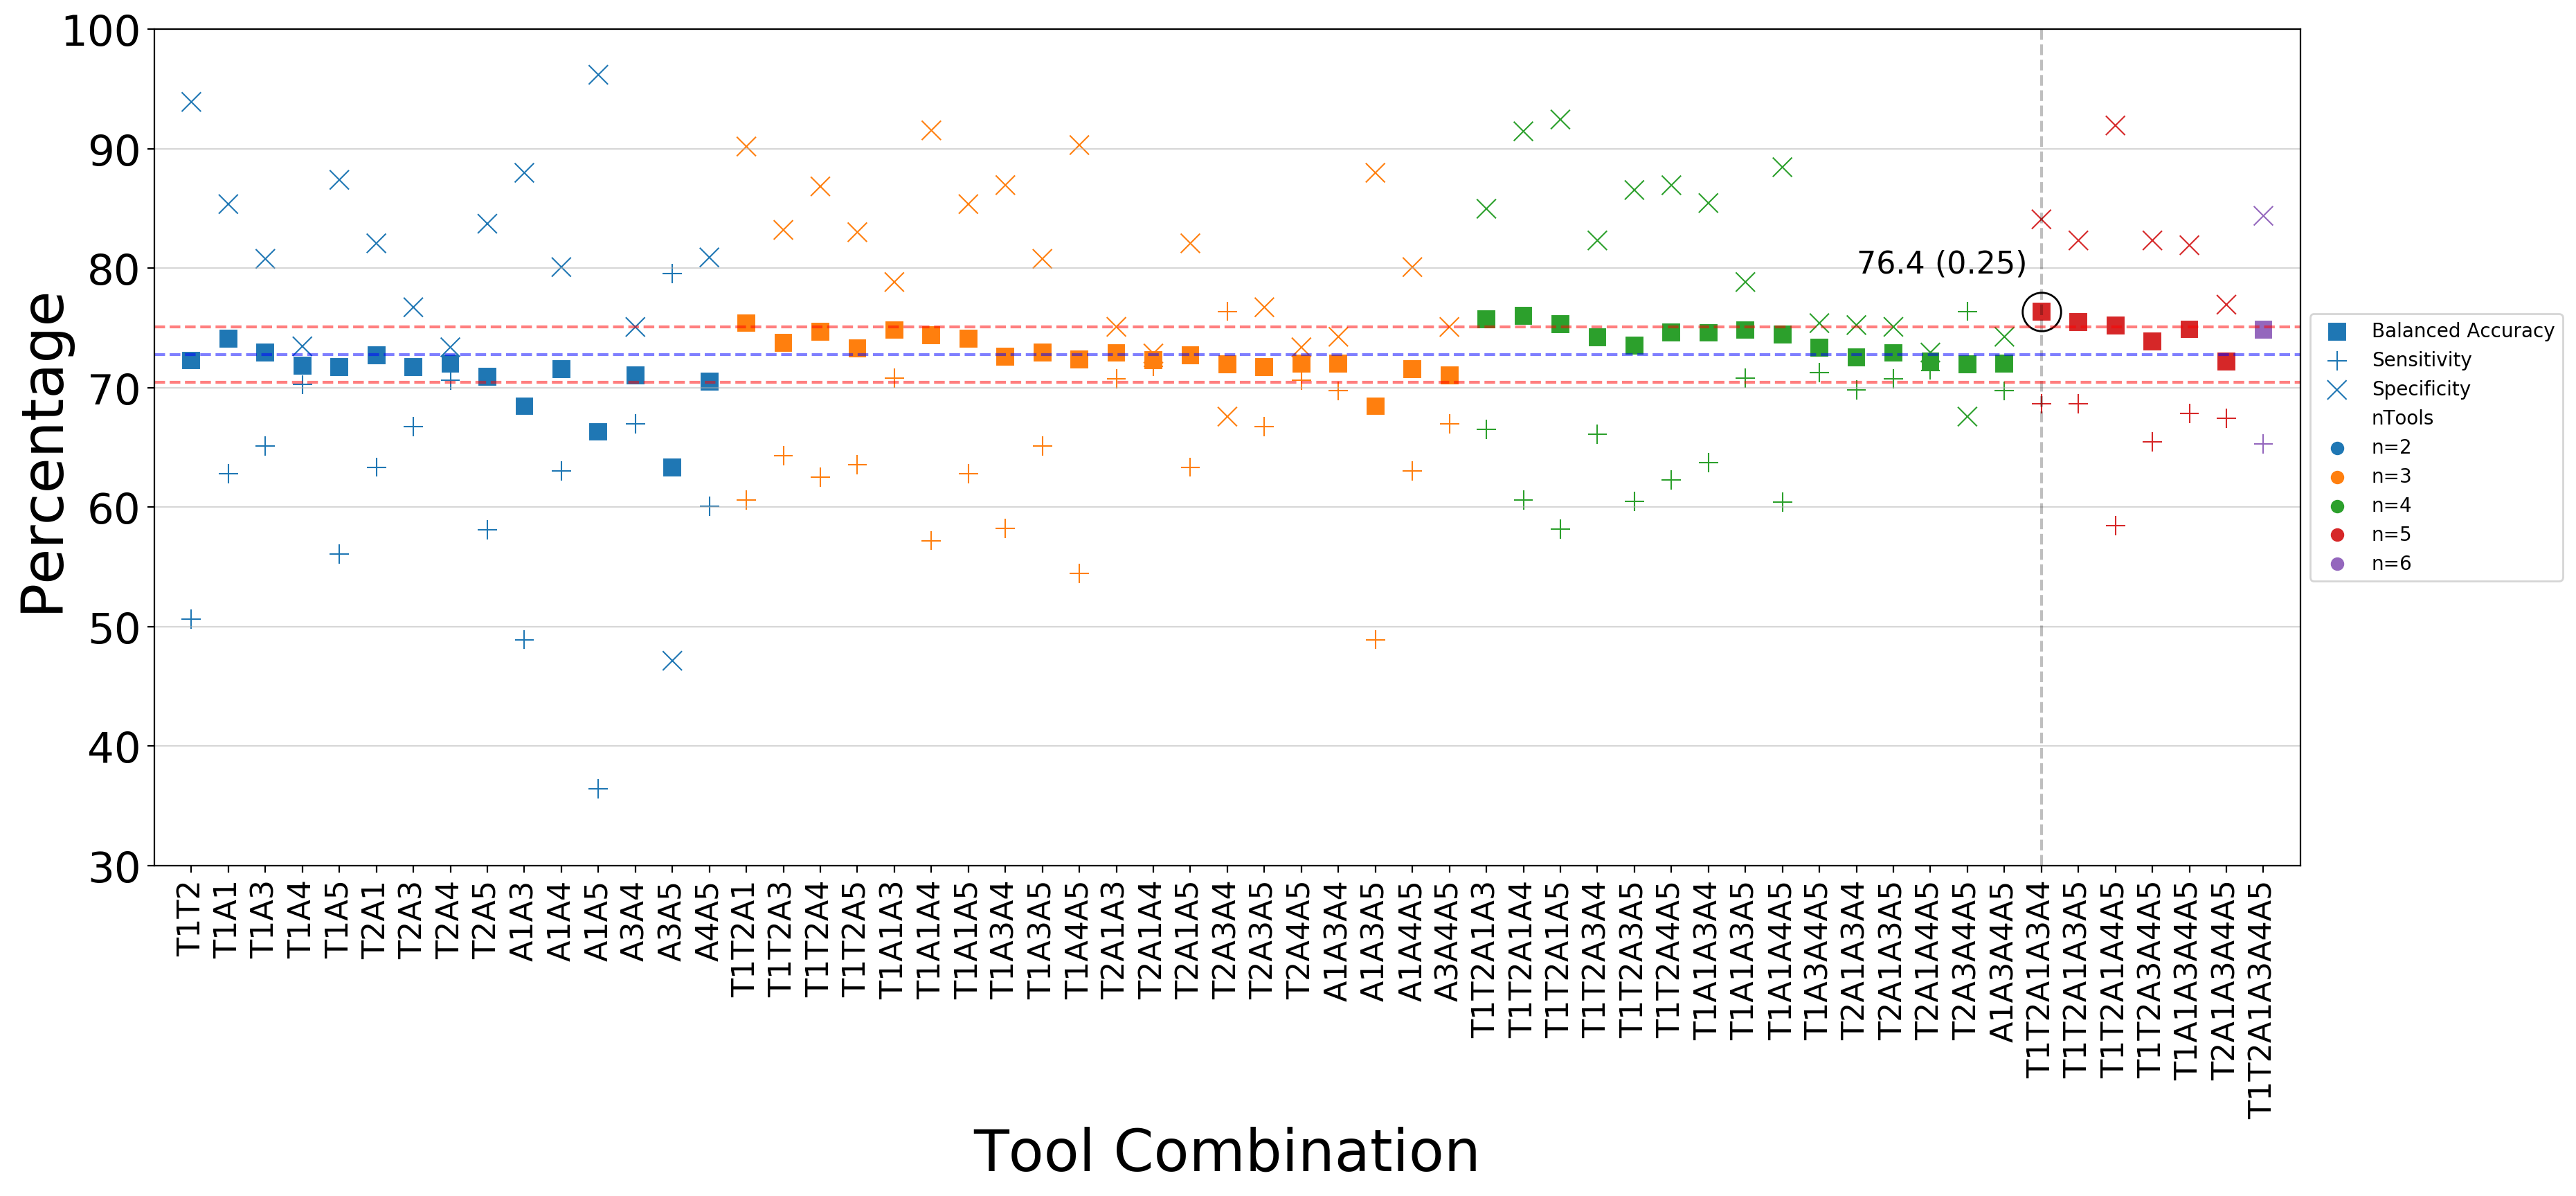

In [149]:
# Combination 2
metrics_x_combns2 = metrics_toplot[metrics_toplot['EnsembleCombination'].str.contains('comb2')]
plt.figure(figsize=(20, 8), dpi = 200)
metrics_x_combns2.nTools=metrics_x_combns2.nTools.astype('category')

ax = sns.scatterplot(x=range(len(metrics_x_combns2)), y = 'Balanced Accuracy', hue='nTools', data=metrics_x_combns2, marker = 's', s=100, label = 'Balanced Accuracy', legend = False)
ax = sns.scatterplot(x=range(len(metrics_x_combns2)), y = 'Sensitivity', hue='nTools', data=metrics_x_combns2, marker = '+', s=100, label = 'Sensitivity', legend = False)
ax = sns.scatterplot(x=range(len(metrics_x_combns2)), y = 'Specificity', hue='nTools', data=metrics_x_combns2, marker = 'x', s=100, label = 'Specificity')

metrics_x_combns2['Balanced Accuracy'] = metrics_x_combns2['Balanced Accuracy'].astype('float')
maxBA = metrics_x_combns2.loc[metrics_x_combns2['Balanced Accuracy'].idxmax()]['Balanced Accuracy']
pcutoff = metrics_x_combns2.loc[metrics_x_combns2['Balanced Accuracy'].idxmax()]['Prediction_CutOff']
maxAccPos = metrics_x_combns2.index.get_loc(metrics_x_combns2['Balanced Accuracy'].idxmax())
plt.plot(maxAccPos,maxBA,marker='o', markersize=20, color = 'k', fillstyle='none')
plt.axvline(maxAccPos, ls = '--', c = 'k', alpha = 0.25)

plt.axhline(y = metrics_x_combns2['Balanced Accuracy'].mean(), ls = '--', c = 'b', alpha = 0.5)
plt.axhline(y = metrics_x_combns2['Balanced Accuracy'].mean()-metrics_x_combns2['Balanced Accuracy'].std() , ls = '--', c = 'r', alpha = 0.5)
plt.axhline(y = metrics_x_combns2['Balanced Accuracy'].mean()+metrics_x_combns2['Balanced Accuracy'].std() , ls = '--', c = 'r', alpha = 0.5)



txt = '%0.1f (%0.2f)' %(maxBA, pcutoff)
plt.annotate(txt, [maxAccPos-5,maxBA+3.25], fontsize = 16)

plt.xticks(range(len(metrics_x_combns2)),xaxis_label, fontsize = 16, rotation = 90)
plt.yticks(fontsize = 22)
plt.xlabel('Tool Combination', size = 30)
plt.ylabel('Percentage', size = 30, labelpad = -5)
#plt.legend(fontsize=14, loc='lower right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([30,100])
plt.xlim([-1,len(metrics_x_combns2)])
plt.grid(which='major', axis='y', alpha=0.5)
plt.savefig(figures_dir+'MetricsCombn2.png', bbox_inches='tight')

#### Build the final model on complete data

In [155]:
final_comb = 'comb2_5-T1T2A1A3A4'
final_comb_post_prob = {}

for comb in x_combns[final_comb].dropna().unique():
    try:
        n_comb = len(x_combns[x_combns[final_comb]==comb])
        n_1_comb = len(x_combns[(x_combns[final_comb]==comb) & (x_combns['demarini']==1)])
        final_comb_post_prob[comb] = round(n_1_comb/n_comb,2)
    except:
        final_comb_post_prob[comb] = np.nan


# Convert dictionary to dataframe and save
final_model = pd.DataFrame.from_dict(final_comb_post_prob, orient='index', columns=['Probability'])
final_model.to_csv(processed_dat_dir+'FinalModel.csv', index_label='Combination')

In [157]:
final_model.head()

,Probability
23.0,0.54
18.0,0.23
0.0,0.15
19.0,0.47
28.0,0.14


In [163]:
#pd.read_csv(processed_dat_dir+'FinalModel.csv')

In [159]:
# 2. Load posterior probability distribution from available data and set the cut-off value
######################################################################################################
# combination = 'comb2_5-T1T2A1A3A4'
#final_model =  pd.read_csv('output/FinalModel.csv', index_col='Combination')
cut_off = 0.25

#%%
######################################################################################################
# 3. Input data for new chemical and predict 
######################################################################################################
print("Enter the tool predictions for the test chemical")
t1 = int(input("EPA TEST Prediction:"))
t2 = int(input("LAZAR Prediction:"))
a1 = int(input("OECD Alert 1 Prediction:"))
a3 = int(input("OECD Alert 3 Prediction:"))
a4 = int(input("OECD Alert 4 Prediction:"))

# calculate the combination number 
comb = 2**0*t1+2**1*t2+2**2*a1+2**3*a3+2**4*a4

# compare the posterior probability with the cut-off and make a prediction
try:
   post_prob = final_model.loc[comb][0]
   if post_prob>cut_off:
       print("The chemical is genotoxic")
   else:
        print("The chemical is non-genotoxic")
except:
    print("The chemical is out of domain for prediction")
    

Enter the tool predictions for the test chemical


EPA TEST Prediction: 1
LAZAR Prediction: 2
OECD Alert 1 Prediction: 1
OECD Alert 3 Prediction: 2
OECD Alert 4 Prediction: 3


The chemical is out of domain for prediction
